In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import model_selection
from tensorflow.keras.optimizers import Adam
import glob
import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [5]:
def make_pair(folderpath):
  file_list = glob.glob(folderpath+'/*.jpg')

  file_list_1=[]
  file_list_2=[]

  file_target =[]
  for path in tqdm.tqdm(file_list):
     file_list_1.append(path)
     file_list_2.append(path)
     file_target.append(1)

     while True:
      n = np.random.randint(0,len(file_list))
      if file_list[n] != path:
        file_list_1.append(path)
        file_list_2.append(file_list[n])
        file_target.append(0)
        break


  data_dic = {'image_1' : file_list_1,
                  'image_2' : file_list_2,
                  'target' : file_target
                  }
  dataset = pd .DataFrame(data_dic)

  return dataset



In [6]:
df = make_pair('/content/img_align_celeba/img_align_celeba').iloc[ :10000]


100%|██████████| 202599/202599 [00:01<00:00, 139774.14it/s]


In [7]:
df.head()

,image_1,image_2,target
0,/content/img_align_celeba/img_align_celeba/141...,/content/img_align_celeba/img_align_celeba/141...,1
1,/content/img_align_celeba/img_align_celeba/141...,/content/img_align_celeba/img_align_celeba/131...,0
2,/content/img_align_celeba/img_align_celeba/145...,/content/img_align_celeba/img_align_celeba/145...,1
3,/content/img_align_celeba/img_align_celeba/145...,/content/img_align_celeba/img_align_celeba/187...,0
4,/content/img_align_celeba/img_align_celeba/012...,/content/img_align_celeba/img_align_celeba/012...,1


In [8]:
train ,test = model_selection.train_test_split(df,random_state= 42 ,test_size=0.1 ,stratify= df.target)
train.shape , test.shape

((9000, 3), (1000, 3))

In [9]:
def read_image(x,y):
  x1,x2 = x

  x1 = tf.io.read_file(x1)
  x1 = tf.image.decode_jpeg(x1 ,channels=3)
  x1 = tf.image.convert_image_dtype(x1,tf.float32)
  x1 = tf.image.resize(x1,(244,244))
  x1 = tf.clip_by_value (x1, 0.0 ,0.1)

  x2 = tf.io.read_file(x2)
  x2 = tf.image.decode_jpeg(x2 ,channels=3)
  x2 = tf.image.convert_image_dtype(x2,tf.float32)
  x2 = tf.image.resize(x2,(244,244))
  x2 = tf.clip_by_value (x2, 0.0 ,0.1)

  return (x1,x2),y


In [10]:
def train_preprocess(x, y):
    x1, x2 = x

    x1 = tf.image.random_flip_left_right(x1)
    x1 = tf.image.random_brightness(x1, max_delta=32.0/255.0)
    x1 = tf.image.random_saturation(x1, lower=0.5, upper=1.5)

    x2 = tf.image.random_flip_left_right(x2)
    x2 = tf.image.random_brightness(x2, max_delta=32.0/255.0)
    x2 = tf.image.random_saturation(x2, lower=0.5, upper=1.5)

    return (x1, x2), y

In [11]:
def dataset_creator(x1, x2, y, training=False):
    data = tf.data.Dataset.from_tensor_slices(((x1, x2), y))
    data = data.shuffle(1028)
    data = data.map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if training:
        data = data.map(train_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    data = data.batch(32)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data


train_dataset = dataset_creator(train.image_1, train.image_2, train.target, training=True)
test_dataset = dataset_creator(test.image_1, test.image_2, test.target, training=False)

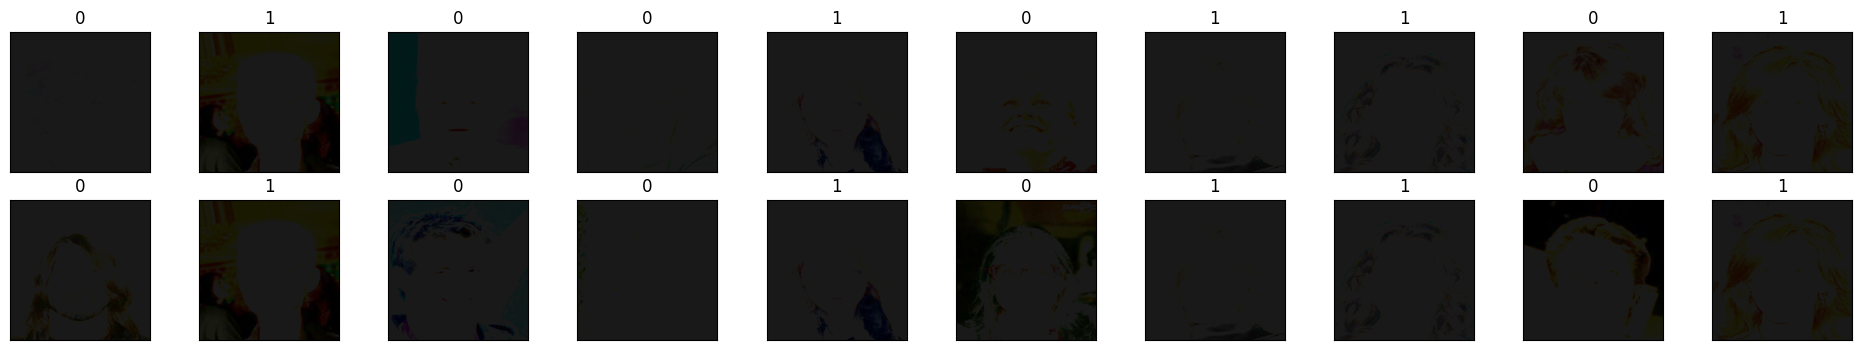

In [17]:
n = 10
plt.figure(figsize=(24, 4))

for x, y in test_dataset.take(1):
    x1, x2 = x

    for i in range(n):

        plt.subplot(2, n, i + 1)
        plt.title(f'{y[i].numpy()}')
        plt.imshow(tf.squeeze(x1[i]), cmap='gray')
        plt.xticks([])
        plt.yticks([])


        plt.subplot(2, n, n + i + 1)
        plt.title(f'{y[i].numpy()}')
        plt.imshow(tf.squeeze(x2[i]), cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.show()

In [19]:
cnn_model = tf.keras.applications.InceptionV3(weights='imagenet',
include_top=False, input_shape=(244, 244, 3))

cnn_model.trainable = False
cnn_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 121, 121, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 121, 121, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 121, 121, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 119, 119, 32)   │          9,216 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 119, 119, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 119, 119, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 119, 119, 64)   │         18,432 │ activation_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 119, 119, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 119, 119, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 59, 59, 64)     │              0 │ activation_12[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 59, 59, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 59, 59, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 59, 59, 80)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [20]:
class SiameseModel(tf.keras.Model):
    def __init__(self, cnn_model):
        super(SiameseModel, self).__init__()
        self.cnn_model = cnn_model
        self.d1 = tf.keras.layers.Dense(512, use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.d2 = tf.keras.layers.Dense(128, use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)

    def call(self, inputs):
        x1, x2 = inputs
        x1 = self.cnn_model(x1)
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
        x2 = self.cnn_model(x2)
        x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

        x = tf.keras.layers.concatenate([x1, x2])
        x = self.d1(x)
        x = self.bn1(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = self.d2(x)
        x = self.bn2(x)
        x = tf.keras.layers.Activation('relu')(x)
        output = self.out(x)
        return output

    def build_model(self, dim=[244,244,3]):
        input1 = tf.keras.layers.Input(shape=dim)
        input2 = tf.keras.layers.Input(shape=dim)
        output = self.call([input1, input2])
        return tf.keras.Model(inputs=[input1, input2], outputs=output)


model = SiameseModel(cnn_model)
siamese_model = model.build_model(dim=[244, 244, 3])
siamese_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 6, 6, 2048)     │     21,802,784 │ input_layer_6[0][0],   │
│                           │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[1][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 4096)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │      2,097,152 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 512)            │          2,048 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_104            │ (None, 512)            │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,536 │ activation_104[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 128)            │            512 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_105            │ (None, 128)            │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            129 │ activation_105[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,968,161 (91.43 MB)

 Trainable params: 2,164,097 (8.26 MB)

 Non-trainable params: 21,804,064 (83.18 MB)

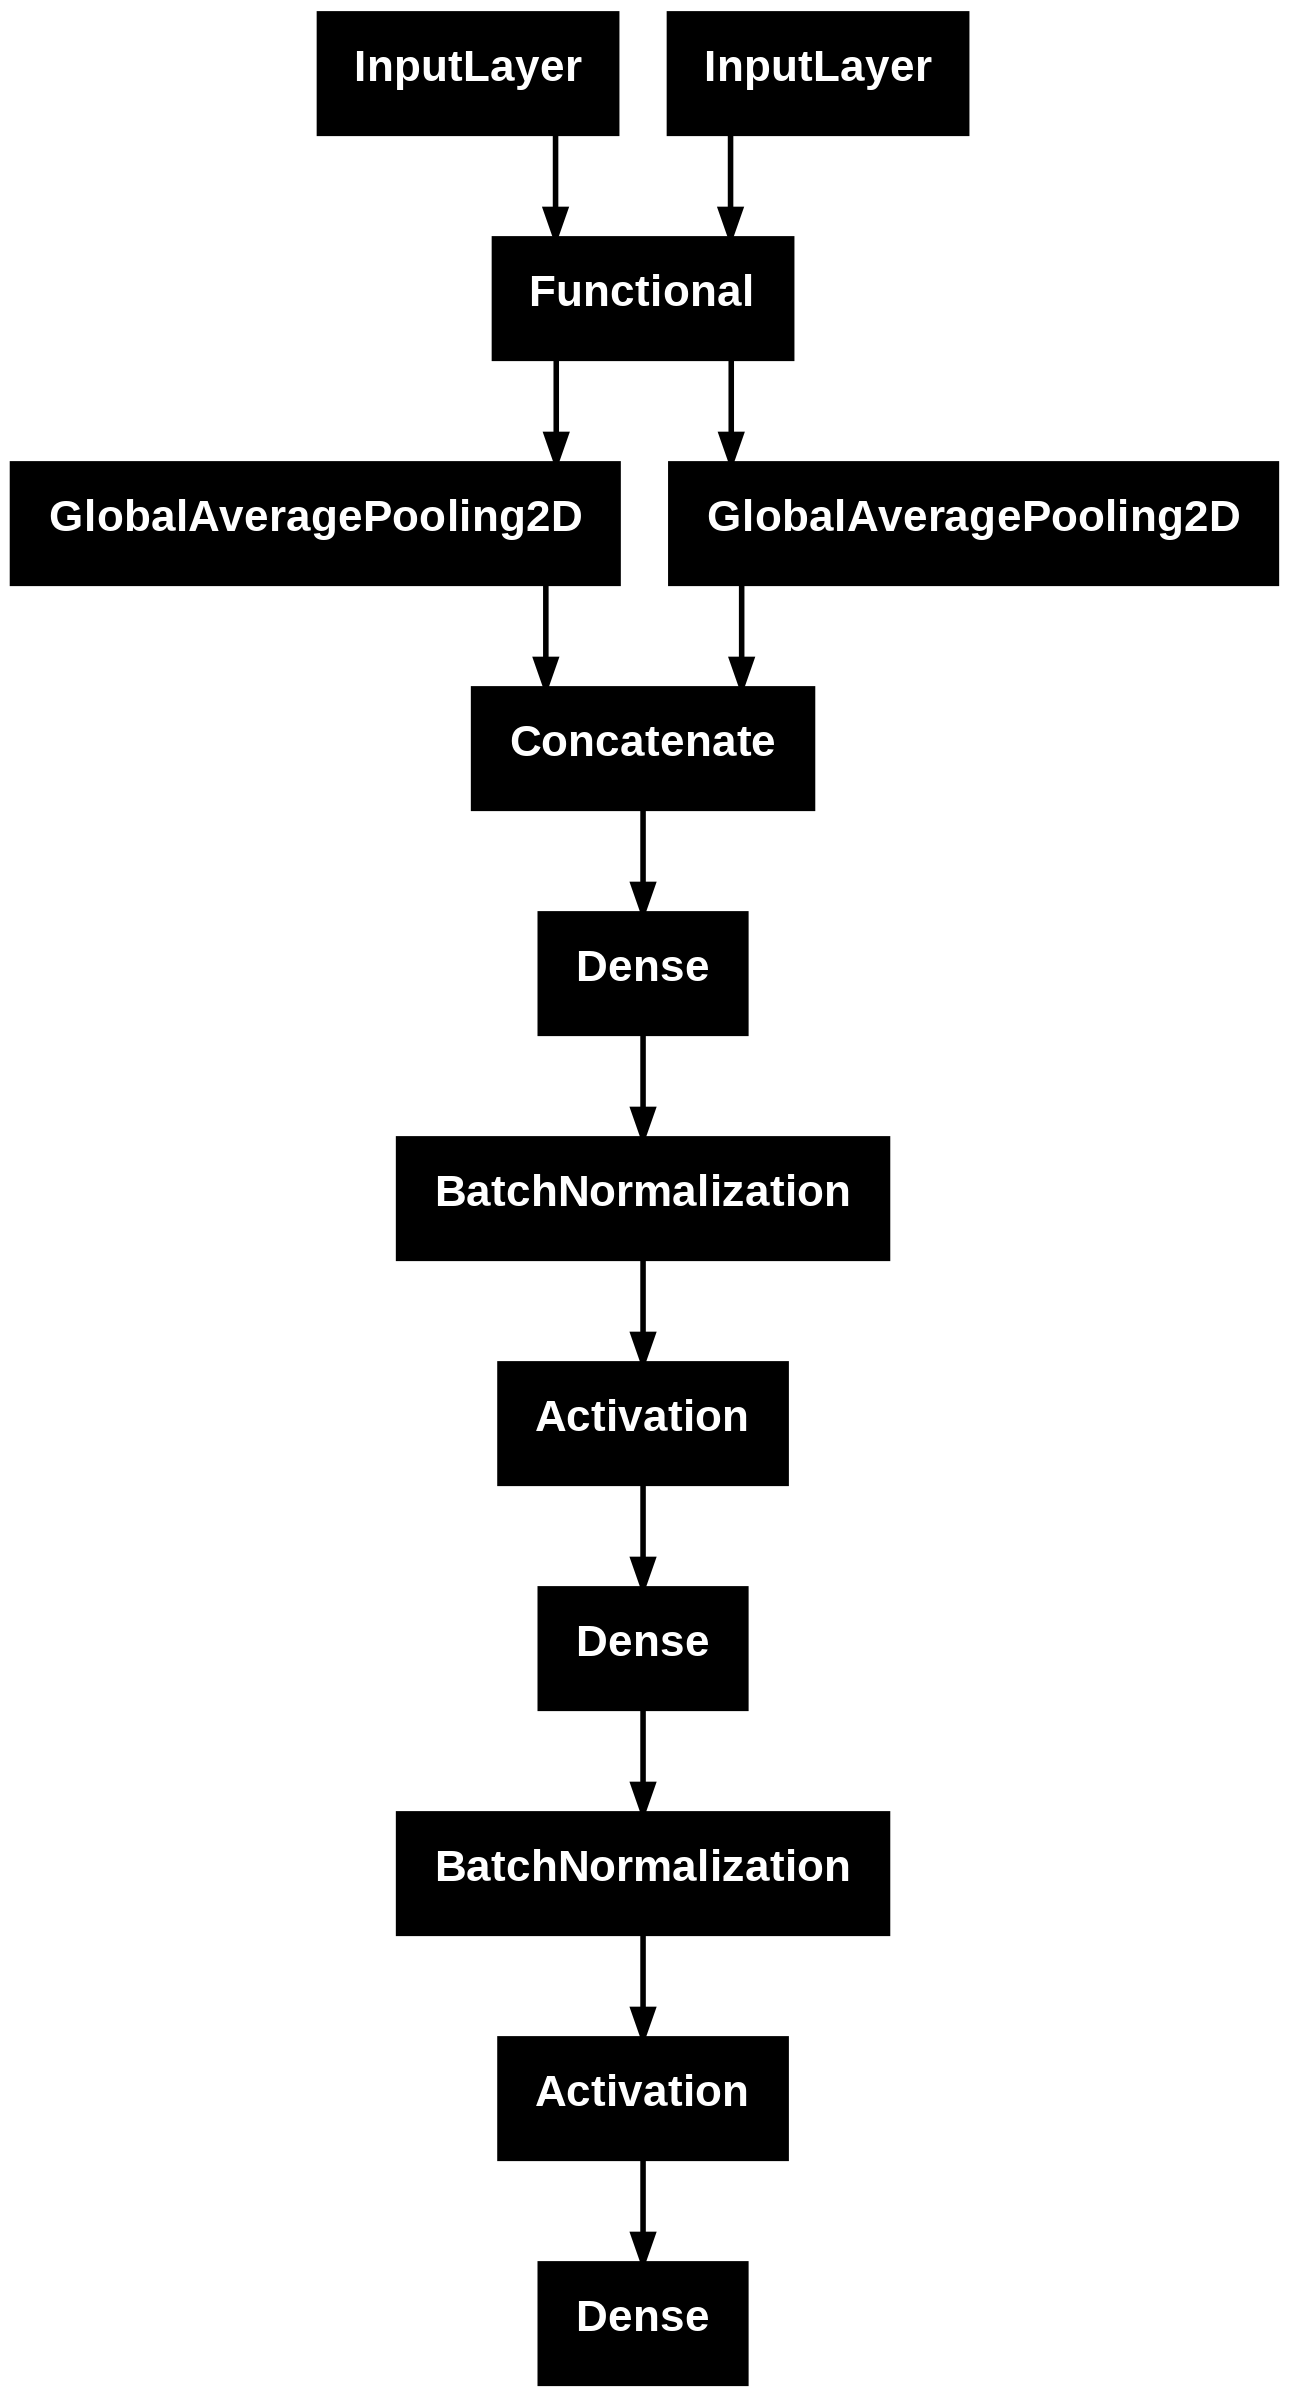

In [21]:
tf.keras.utils.plot_model(model.build_model(dim=[244,244,3]))

In [22]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 100s 263ms/step - accuracy: 0.6065 - loss: 0.6650 - val_accuracy: 0.7730 - val_loss: 0.5512
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 102s 168ms/step - accuracy: 0.7567 - loss: 0.5480 - val_accuracy: 0.8120 - val_loss: 0.4579
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 172ms/step - accuracy: 0.7802 - loss: 0.4858 - val_accuracy: 0.8120 - val_loss: 0.4124
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 48s 170ms/step - accuracy: 0.7914 - loss: 0.4581 - val_accuracy: 0.8380 - val_loss: 0.3780
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 173ms/step - accuracy: 0.7993 - loss: 0.4372 - val_accuracy: 0.8240 - val_loss: 0.3689
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.8152 - loss: 0.4084 - val_accuracy: 0.8340 - val_loss: 0.3484
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.8239 - loss: 0.3993 - val_accuracy: 0.8690 - val_loss: 0.3209
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.8386 - loss:

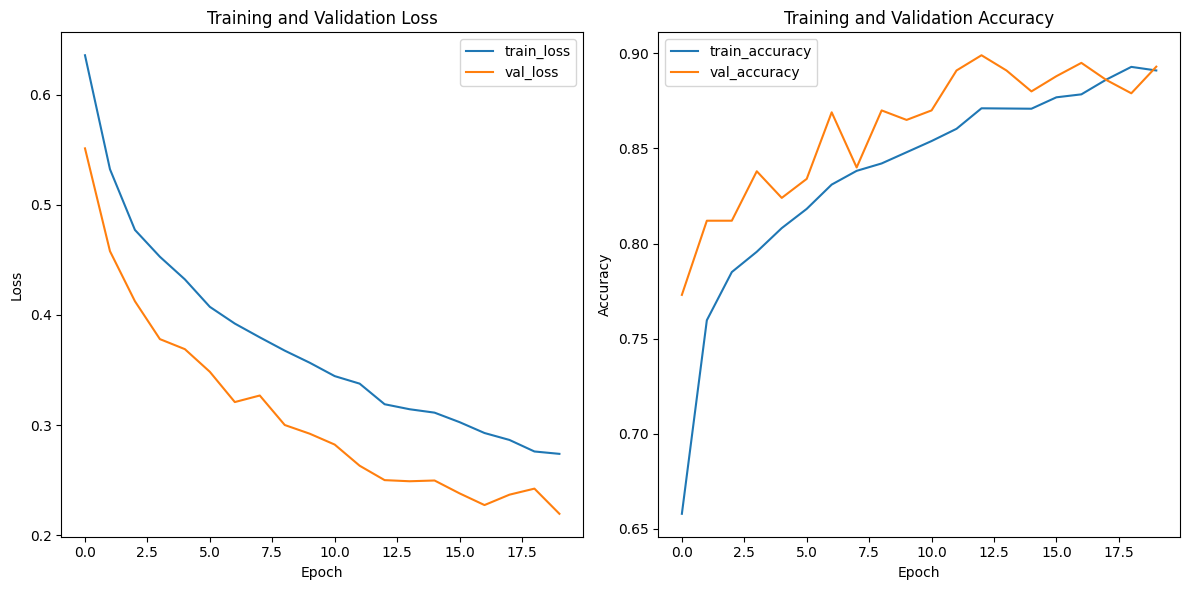

In [23]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Save the model
model.save("/content/drive/MyDrive/trained_model5_inceptionv3old.h5")